In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_goiania.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_manaus.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_sao_luiz.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_belem.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_curitiba.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_salvador.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_sao_paulo.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_macapa.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_rio.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_vitoria.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_recife.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_fortaleza.csv


# Import librairies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-05-13 21:59:30.889048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 21:59:30.889150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 21:59:31.010906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [3]:
train_data_rio = pd.read_csv('/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_rio.csv')

In [4]:
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [5]:
train_data_rio.shape

(47, 18)

# Preprocess data

## _Unipivot data (melt)

In [6]:
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6, 'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

train_data_rio = train_data_rio[['YEAR'] + list(months_dict.keys())]
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84


In [7]:
df_rio = pd.melt(train_data_rio, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict}) # replaces month names to month numbers.

df_rio.head()

/tmp/ipykernel_24/1786242505.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  value_name='Sum of Value').replace({"MONTH": months_dict}) # replaces month names to month numbers.


,YEAR,MONTH,Sum of Value
0,1973,1,27.73
1,1974,1,26.68
2,1975,1,25.27
3,1976,1,27.48
4,1977,1,27.13


In [8]:
df_rio["DAY"] = 1
df_rio['DATE'] = pd.to_datetime(df_rio[['YEAR','MONTH','DAY']])
df_rio = df_rio.rename(columns = {'Sum of Value':'TEMP'})
df_rio = df_rio.sort_values("DATE").reset_index(drop=True)

df_rio = df_rio.drop(["YEAR", "MONTH", "DAY"], axis = 1)
df_rio = df_rio.set_index('DATE', drop = True)

In [9]:
df_rio.head()

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


In [10]:
df_rio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1973-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


## _Interpolate data

In [11]:
print(df_rio["TEMP"].min(), df_rio["TEMP"].max(), df_rio["TEMP"].mean())

19.24 999.9 105.56517730496454


In [12]:
df_rio.replace(999.90, np.nan, inplace = True)
df_rio_intp = df_rio.interpolate()

In [13]:
print(df_rio_intp["TEMP"].min(), df_rio_intp["TEMP"].max(), df_rio_intp["TEMP"].mean())

19.24 30.25 24.390939716312058


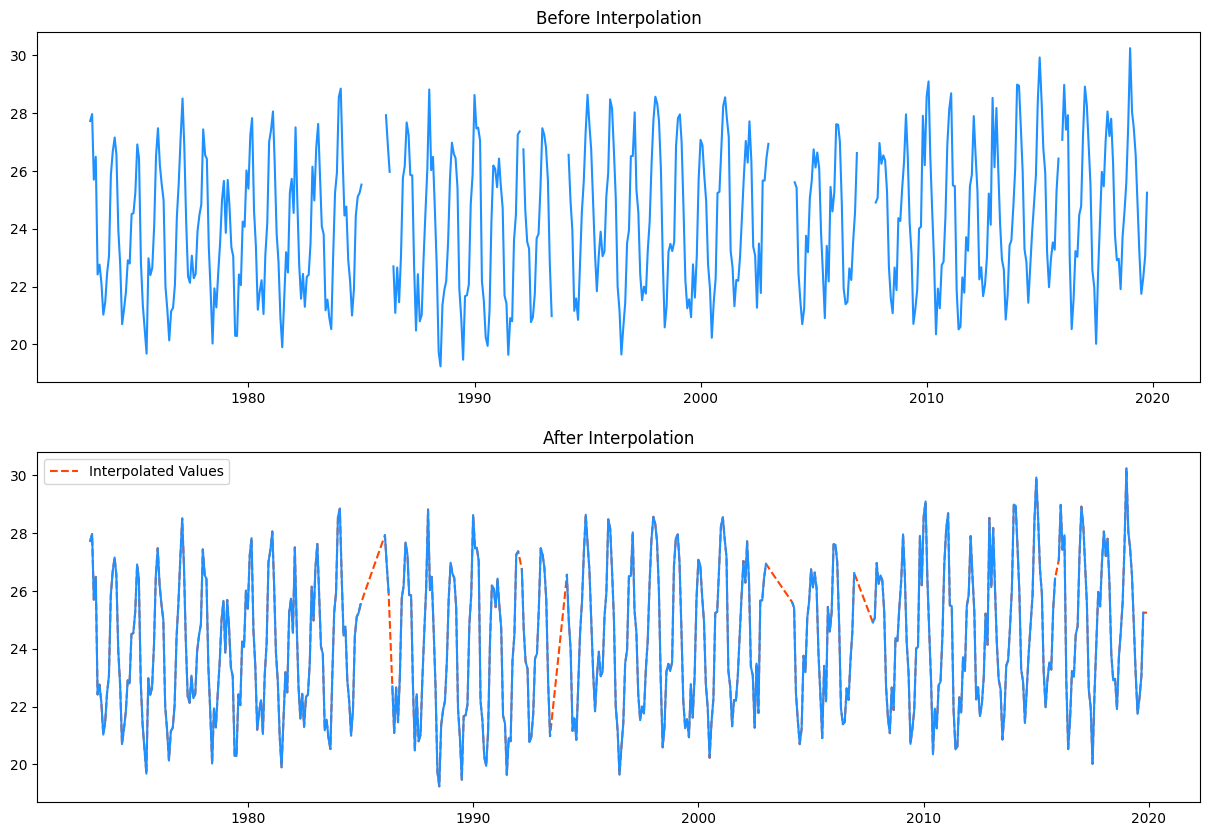

In [14]:
rows = 2
cols = 1

fig, axs = plt.subplots(2, figsize = (15, 10))

axs[0]
axs[0].set_title('Before Interpolation')
axs[0].plot(df_rio, color = 'dodgerblue')

axs[1].plot(df_rio_intp, color = 'orangered', linestyle = '--', label = 'Interpolated Values')
legend = plt.legend(loc = 'upper left')
axs[1].set_title("After Interpolation")
axs[1].plot(df_rio, color = 'dodgerblue')

plt.show()

## _Scaling

In [15]:
temp = df_rio_intp.filter(["TEMP"])
temp_values = temp.values

train_data_len = int(np.ceil(len(temp_values) * .95)) # Use 95% of data for training

train_data_len

536

In [16]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(temp_values)

In [17]:
scaled_data.shape

(564, 1)

In [18]:
scaled_data[:5]

array([[0.77111717],
       [0.79291553],
       [0.58673933],
       [0.65849228],
       [0.28882834]])

In [19]:
df_rio_intp.head(5)

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


# Train test split

In [20]:
train_data = scaled_data[0:train_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        #print(X_train)
        #print(y_train)
        print()

print(f'X length: {len(X_train)}')
print(f'y length: {len(y_train)}')



X length: 476
y length: 476


In [21]:
X_train, y_train = np.array(X_train), np.array(y_train)

#reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
print(X_train.shape, y_train.shape)

(476, 60, 1) (476,)


In [23]:
test_data = scaled_data[train_data_len - 60 :, : ]
X_test = []
y_test = temp_values[train_data_len: , : ]

for i in range(60, len(test_data)):
    X_test.append(test_data[i -60: i, 0])

print(f'X length: {len(X_test)}')
print(f'y length: {len(y_test)}')    

X_test = np.array(X_test)

# Reshaping the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X length: 28
y length: 28


In [24]:
print(X_test.shape, y_test.shape)

(28, 60, 1) (28, 1)


# Build model

In [25]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 1)

Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0652
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0147
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0119
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0109
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0112
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0101
Epoch 10/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0115


# Prediction

In [27]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


In [28]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1.2914402054639

In [29]:
predictions.shape

(28, 1)

/tmp/ipykernel_24/942209198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


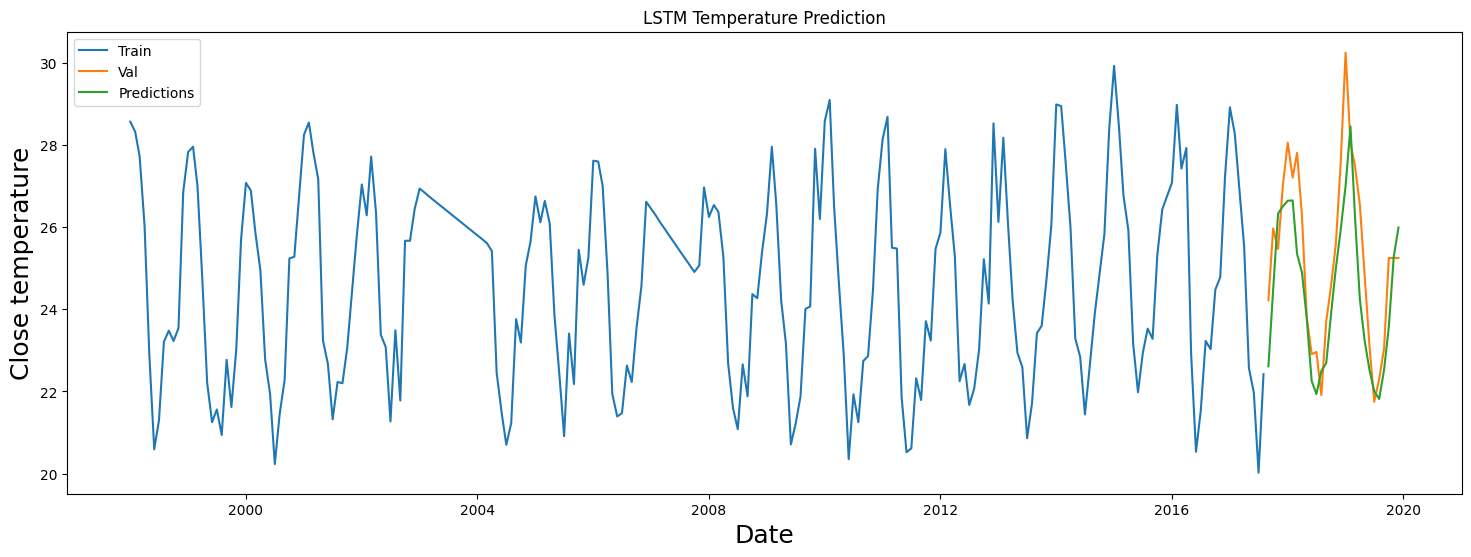

In [30]:
train = temp[300:train_data_len]
valid = temp[train_data_len:]
valid['Predictions'] = predictions

# plotting the results
plt.figure(figsize = (18, 6))
plt.title('LSTM Temperature Prediction')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close temperature', fontsize = 18)
plt.plot(train['TEMP'])
plt.plot(valid[['TEMP', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'upper left')
plt.show()

In [31]:
valid.shape

(28, 2)

In [32]:
valid.head()

,TEMP,Predictions
DATE,,
2017-09-01,24.22,22.611656
2017-10-01,25.97,24.484684
2017-11-01,25.47,26.334366
2017-12-01,27.01,26.506021
2018-01-01,28.06,26.645094
